# `CLOUD.jl` - 2D linear advection

In [43]:
using CLOUD
using OrdinaryDiffEq
using LinearAlgebra
using TimerOutputs
plots_path = "../plots/advection_dgsem_2D/"
results_path = "../results/advection_dgsem_2D/";

┌ Error: Failed to revise /Users/tristanmontoya/Research/CLOUD.jl/src/SpatialDiscretizations/SpatialDiscretizations.jl
│   exception = Revise.ReviseEvalException("/Users/tristanmontoya/Research/CLOUD.jl/src/SpatialDiscretizations/SpatialDiscretizations.jl:9", UndefVarError(:TensorProducts), Any[(top-level scope at SpatialDiscretizations.jl:9, 1)])
└ @ Revise /Users/tristanmontoya/.julia/packages/Revise/3RMhb/src/packagedef.jl:714


Define the physical problem

In [44]:
θ = π/4
a = sqrt(2)
A = 1.0  # amplitude
L = 1.0  # domain length
k = (2*π/L, 2*π/L)  # wave number
T = 1.0/(a*max(abs(cos(θ)),abs(cos(θ))))  # end time
initial_data = InitialDataSine(A,k)
conservation_law = linear_advection_equation((a*cos(θ),a*sin(θ)),λ=1.0);

Set up a DGSEM scheme of degree `p` with `M` elements

In [45]:
M = 4  # number of elements
p = 3  # degree of discretization
reference_approximation=ReferenceApproximation(
    DGSEM(p), Quad(), N_plot=ceil(Int,50/M), sum_factorize=true);
spatial_discretization = SpatialDiscretization(
    uniform_periodic_mesh(reference_approximation.reference_element, 
        ((0.0,L),(0.0,L)), (M,M)), reference_approximation);
results_path = save_project(conservation_law,
     spatial_discretization, initial_data,
     WeakConservationForm(), (0.0, T), Lazy(),
     results_path, overwrite=true, clear=true)
visualize(spatial_discretization, plots_path, "mesh.pdf")

LoadError: UndefVarError: TensorProductMap not defined

Run the `OrdinaryDiffEq` solver with RK4, taking `n_s` snapshots

In [ ]:
reset_timer!()
n_s = 10
dt_scale=0.1
dt = dt_scale*(L/M)/(norm(a)*(2*p+1))
ode_problem = semidiscretize(load_project(results_path)...)
save_solution(ode_problem.u0, 0.0, results_path, 0)
sol = solve(ode_problem, RK4(), adaptive=false,
    dt=dt, save_everystep=false,
    callback=save_callback(results_path, ceil(Int, T/(dt*n_s))))
save_solution(last(sol.u), last(sol.t), results_path, "final")
print_timer()

LoadError: transpose not implemented for 16×16 LinearMaps.FunctionMap{Float64}(apply!; ismutating=true, issymmetric=false, ishermitian=false, isposdef=false)

Visualize the solution

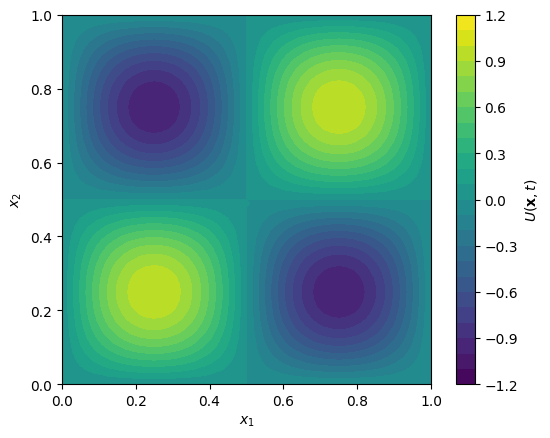

In [ ]:
plotter = Plotter(spatial_discretization, plots_path)
visualize(initial_data, plotter, "exact.pdf", u_range=[-1.0,1.0], contours=25,
    label="U(\\mathbf{x},t)")

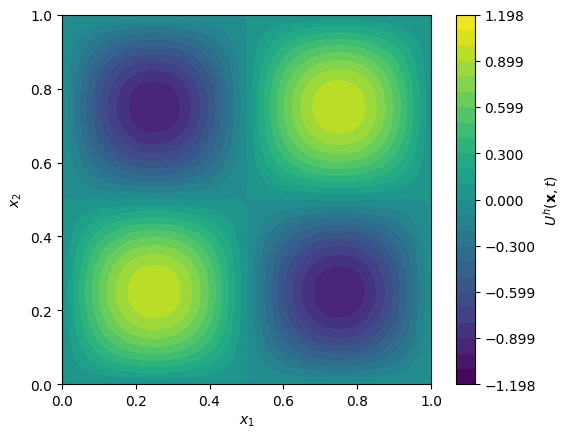

In [ ]:
visualize(last(sol.u),plotter, "approx.pdf", contours=25, 
    label="U^h(\\mathbf{x},t)")

Calculate the integral L<sup>2</sup> error norm

In [ ]:
error_analysis = ErrorAnalysis(conservation_law, spatial_discretization, results_path)
print("L2 error: ", analyze(error_analysis, last(sol.u), initial_data)[1])

L2 error: 0.004200833104122927

In [ ]:
reference_approximation.reference_element.rstq[1]

16-element Vector{Float64}:
 -1.0
 -0.4472135954999579
  0.4472135954999579
  1.0
 -1.0
 -0.4472135954999579
  0.4472135954999579
  1.0
 -1.0
 -0.4472135954999579
  0.4472135954999579
  1.0
 -1.0
 -0.4472135954999579
  0.4472135954999579
  1.0

In [ ]:
reference_approximation.reference_element.rstf[1]

16-element Vector{Float64}:
 -1.0
 -1.0
 -1.0
 -1.0
  1.0
  1.0
  1.0
  1.0
 -1.0
 -0.4472135954999579
  0.4472135954999579
  1.0
 -1.0
 -0.4472135954999579
  0.4472135954999579
  1.0

In [ ]:
reference_approximation.reference_element.rstf[2]

16-element Vector{Float64}:
 -1.0
 -0.4472135954999579
  0.4472135954999579
  1.0
 -1.0
 -0.4472135954999579
  0.4472135954999579
  1.0
 -1.0
 -1.0
 -1.0
 -1.0
  1.0
  1.0
  1.0
  1.0